In [2]:
from lja.analyser.analyser import Analyser
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick

In [3]:
!pwd

/Users/fredericbecker/Documents/Master/layerwise_jacobian_analysis/report/notebooks


In [4]:
%cd '/Users/fredericbecker/Documents/Master/layerwise_jacobian_analysis/'

/Users/fredericbecker/Documents/Master/layerwise_jacobian_analysis


### Load Analyser Object

In [5]:
analyser = Analyser("mnist/dropout/", show_plots=False)
analyser.load(side="left", load_features=True)

Loading data ...


In [6]:
# set settings
analyser.plotter.plot_path = "report/plots"
analyser.set_k_per_layer([20, 10, 10, 10])

### U Embedding plot

In [ ]:
datas = []
labels = ['incorrect' if el  else 'correct' for el in analyser.data.misclassification_mask]

for layer in [0,1,2,3]:
    # aggregate data
    U = analyser.data.u_list[layer]
    U_flatten = U.reshape(U.shape[0], U.shape[1] * U.shape[2])
    
    # perform t-SNE
    res = TSNE(
        2, init="pca", learning_rate="auto", n_iter=2000, n_jobs=1
    ).fit_transform(U_flatten)
    
    def standardise(x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))
        
    # remember data
    data = pd.DataFrame(
        {
            "x": standardise(res[:, 0]),
            "y": standardise(res[:, 1]),
            "Class": analyser.data.labels,
            "Classification": labels
        }
    )
    datas.append(data)

In [1]:
# plot
sns.set(rc={"figure.figsize":(15, 15)})
fig, ax = plt.subplots(2,2)
axs = ax.flatten()

for layer, data in enumerate(datas):
    
    sns.scatterplot(
        x="x",
        y="y",
        hue="Class",
        style="Classification",
        palette=sns.color_palette(n_colors=len(set(data["Class"]))),
        data=datas[layer],
        ax=axs[layer],
        s=120,
    );

    # design
    axs[layer].set(xlabel=None, ylabel=None)
    axs[layer].set(xticklabels=[], yticklabels=[])
    axs[layer].set_title('Layer '+ str(layer+1), size = 26)
    axs[layer].get_legend().remove()

    #plt.title('Layer ' + str(layer), fontdict = {'fontsize' : 22})
    
#plt.legend(loc='lower right', title='Class', fontsize='20', title_fontsize='22')

handles, labels = axs[layer].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.19, 0.65),
           fontsize=24, title_fontsize='26')


#plt.suptitle('t-SNE embedding of the output projections', size=28, y=1)
plt.tight_layout()
plt.savefig('report/plots/tsne_plot.png', bbox_inches=Bbox([[0, 0], [17.9, 15]])) #15.1

pass;

NameError: name 'sns' is not defined

### Exemplary Decision Traces

In [20]:
analyser.compute_computation_path_per_layer(printing=True, samples=[935, 622, 700]);


Sample: 935
Read in:   [0. 1. 1. 1.]
Write out: [1. 9. 9. 1.]

Sample: 622
Read in:   [0. 0. 0. 0.]
Write out: [0. 0. 0. 0.]

Sample: 700
Read in:   [0. 7. 7. 7.]
Write out: [7. 7. 7. 7.]


In [22]:
analyser.compute_computation_path_per_k(printing=True, samples=[935, 622, 700]);


Sample: 935

Layer: 0
Write out:  [1. 8. 1. 1. 1. 1. 1. 1. 1. 1.]

Layer: 1
Read in:    [7. 1. 1. 1. 1. 1. 1. 7. 1. 1.]
Write out:  [1. 9. 7. 9. 9. 1. 7. 7. 9. 8.]

Layer: 2
Read in:    [1. 1. 1. 1. 1. 1. 1. 7. 1. 9.]
Write out:  [9. 9. 9. 9. 9. 1. 9. 9. 9. 9.]

Layer: 3
Read in:    [7. 1. 1. 7. 1. 1. 0. 7. 1. 7.]
Write out:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Sample: 622

Layer: 0
Write out:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 6.]

Layer: 1
Read in:    [6. 0. 0. 0. 6. 0. 0. 0. 0. 3.]
Write out:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Layer: 2
Read in:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Write out:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Layer: 3
Read in:    [0. 0. 0. 0. 6. 0. 0. 0. 0. 0.]
Write out:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Sample: 700

Layer: 0
Write out:  [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]

Layer: 1
Read in:    [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
Write out:  [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]

Layer: 2
Read in:    [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
Write out:  [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]

Layer: 3
Read 

### Correct decision per layer

In [7]:
u_path, _ = analyser.compute_computation_path_per_layer()
mask = analyser.data.misclassification_mask

In [9]:
correct = np.array([u_path[:, l] == analyser.data.labels for l in range(4)])
cl_mis = np.sum(correct[:, mask], axis= 1)
cl_cor = np.sum(correct[:, mask == 0], axis= 1)

cl_percentage = (cl_cor/np.sum(mask == 0), 
                cl_mis/np.sum(mask))

cl_percentage

(array([0.91281513, 0.96848739, 0.98109244, 1.        ]),
 array([0.25      , 0.41666667, 0.33333333, 0.        ]))

### Final Decision Layer

In [10]:
final_decision_layer = analyser.get_layer_of_final_decision() + 1
mask = analyser.data.misclassification_mask

In [11]:
d_mis = final_decision_layer[mask]
d_cor = final_decision_layer[mask == 0]

d_percentage = (np.histogram(d_cor, bins = 4)[0]/len(d_cor), 
                np.histogram(d_mis, bins = 4)[0]/len(d_mis))

d_percentage

(array([0.89915966, 0.06512605, 0.01680672, 0.01890756]),
 array([0.29166667, 0.125     , 0.125     , 0.45833333]))

### Variation in Decision Trace

In [12]:
variation = analyser.compute_variation_in_computation()
mask = analyser.data.misclassification_mask

In [44]:
d_mis = variation[mask]
d_cor = variation[mask == 0]

d_mis = np.mean(d_mis, axis = 0)
d_cor = np.mean(d_cor, axis = 0)

In [46]:
d_mis[:-1].std()

3.6408632239956877

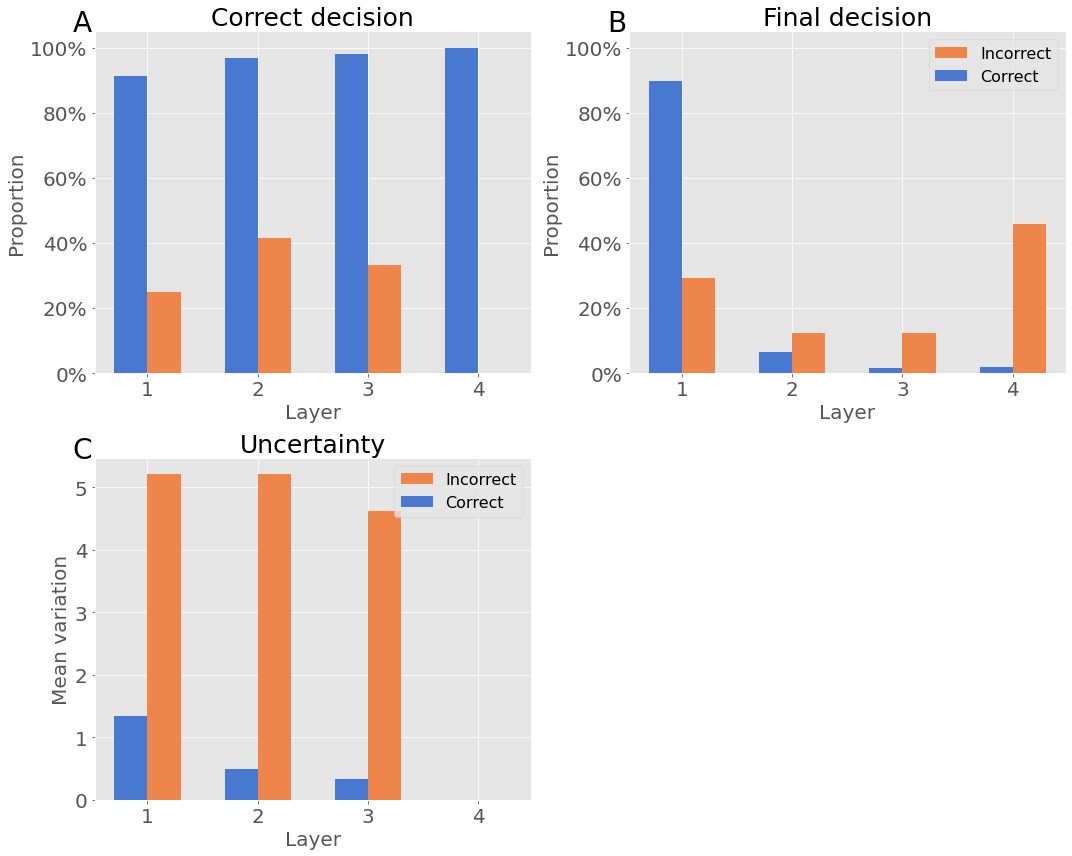

In [37]:
# general design
plt.style.use('ggplot')#
figure, axis = plt.subplots(2, 2, figsize=(15, 12))

# barplot design
bw = 0.3
br1 = np.arange(len(d_percentage[0])) - bw/2 +1
br2 = [x + bw for x in br1]



# plot of correct decision per layer
ax = axis[0][0]
ax.bar(br2, cl_percentage[1], width = bw, color= sns.color_palette("muted")[1])
ax.bar(br1, cl_percentage[0], width = bw, color= sns.color_palette("muted")[0])

# design'
#ax.legend(['Incorrect', 'Correct'], prop={'size': 16})
ax.set_xticks([1,2,3,4])
ax.tick_params(labelsize = 20)
ax.set_ylabel('Proportion', size= 20)
ax.set_xlabel('Layer', size= 20)
ax.set_title('Correct decision', size= 25)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Labeling
ax.annotate("A", xy=(-0.05, 1), xycoords="axes fraction", size = 28)



# plot of final decision layer
ax = axis[0][1]
ax.bar(br2, d_percentage[1], width = bw, color= sns.color_palette("muted")[1])
ax.bar(br1, d_percentage[0], width = bw, color= sns.color_palette("muted")[0])

# design'
ax.legend(['Incorrect', 'Correct'], prop={'size': 16})
ax.set_xticks([1,2,3,4])
ax.set_ylim([0, 1.05])
ax.set_yticks([0,0.2, 0.4, 0.6, 0.8, 1.0])
ax.tick_params(labelsize = 20)
ax.set_ylabel('Proportion', size= 20)
ax.set_xlabel('Layer', size= 20)
ax.set_title('Final decision', size= 25)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Labeling
ax.annotate("B", xy=(-0.05, 1), xycoords="axes fraction", size = 28)


# plot of uncertainty
ax = axis[1][0]
ax.bar(br2, d_mis, width = bw, color= sns.color_palette("muted")[1])
ax.bar(br1, d_cor, width = bw, color= sns.color_palette("muted")[0])

# design'
ax.legend(['Incorrect', 'Correct'], prop={'size': 16})
ax.set_xticks([1,2,3,4], size=20)
ax.tick_params(labelsize = 20)
ax.set_ylabel('Mean variation', size= 20)
ax.set_xlabel('Layer', size= 20)
ax.set_title('Uncertainty', size= 25)

# Labeling
ax.annotate("C", xy=(-0.05, 1), xycoords="axes fraction", size = 28)

figure.delaxes(axis[1][1])
plt.tight_layout()
figure.savefig('report/plots/trace_plot.png', bbox_inches=Bbox([[0, 0], [15, 12]]));

### Feature Validation


Layer: 0
Error: 8.04
Correlation: 0.918
Dot product: 1774679296
Mean Similarity: -7.59

Layer: 1
Error: 7.59
Correlation: 0.966
Dot product: 3019788800
Mean Similarity: 122.68

Layer: 2
Error: 38.56
Correlation: 0.971
Dot product: 5510881792
Mean Similarity: 152.67

Layer: 3
Error: 0.06
Correlation: 0.978
Dot product: 378
Mean Similarity: -19.53


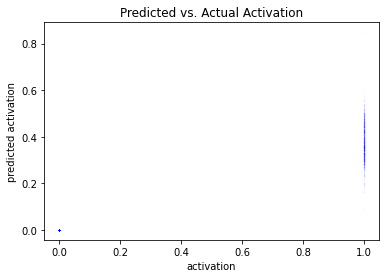

In [6]:
targets, preds = analyser.test_features()

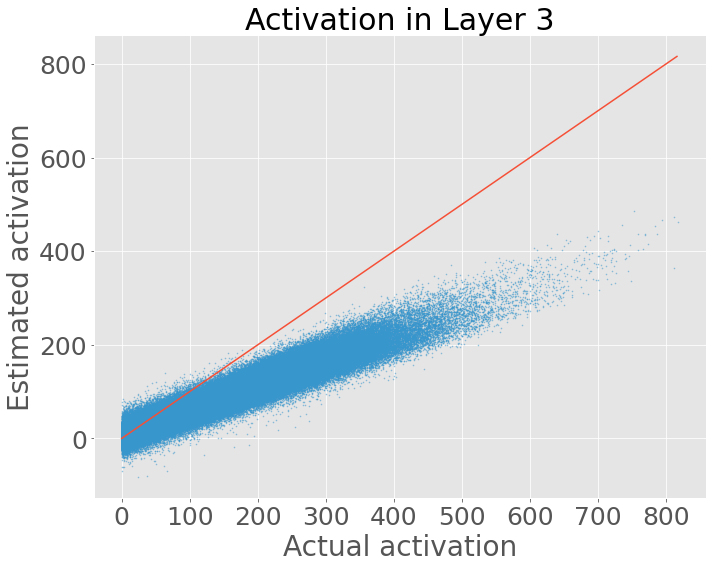

In [14]:
plt.style.use('ggplot')
plt.figure(figsize=(10,8))
l = 2

plt.plot(targets[l], preds[l], 'o', color=(51/235, 138/235, 188/235), alpha=0.5, markersize=0.6)
plt.plot(range(int(np.max(targets[l]))), range(int(np.max(targets[l]))), color=(226/235, 74/235, 51/235))


# design
plt.title('Activation in Layer '+ str(l+1), size= 30)
plt.ylabel('Estimated activation', size= 28)
plt.xlabel('Actual activation', size= 28)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

plt.tight_layout();
plt.savefig('report/plots/activation_layer'+ str(l+1) + '.png');

### SVD Validation


Layer: 0
Stacked side:	 left 
K:		 20 
Size of u:	 (1000, 1024, 20) 
Size of s	 (20,) 
Size of vh	 (20, 785)

Layer: 0
Error: 8.04
Correlation: 0.918
Dot product: 1774643328

Layer: 1
Stacked side:	 left 
K:		 10 
Size of u:	 (1000, 1024, 10) 
Size of s	 (10,) 
Size of vh	 (10, 1025)

Layer: 1
Error: 3.95
Correlation: 0.991
Dot product: 3326288384

Layer: 2
Stacked side:	 left 
K:		 10 
Size of u:	 (1000, 512, 10) 
Size of s	 (10,) 
Size of vh	 (10, 1025)

Layer: 2
Error: 2.18
Correlation: 0.999
Dot product: 9726184448

Layer: 3
Stacked side:	 left 
K:		 10 
Size of u:	 (1000, 10, 10) 
Size of s	 (10,) 
Size of vh	 (10, 513)

Layer: 3
Error: 0.00
Correlation: 1.000
Dot product: 1000


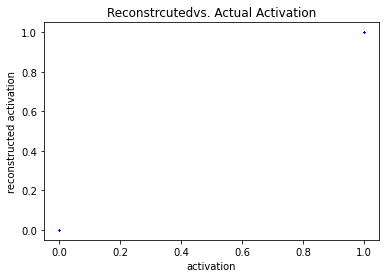

In [8]:
analyser.test_all_decompositions([20, 10, 10, 10])

Stacked side:	 left 
K:		 10 
Size of u:	 (1000, 10, 10) 
Size of s	 (10,) 
Size of vh	 (10, 513)

Layer: 3
Error: 0.00
Correlation: 1.000
Dot product: 1000


(2.8616393e-08, 1.0, 0.9999999999999445, 999.9999)

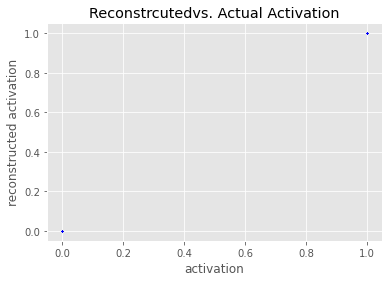

In [16]:
analyser.test_decomposition(3, 10)

In [ ]:
# find decision layer that is late


In [76]:
(u_centers, feature_centers) = analyser.get_class_centers_per_feature_dimension(3)

In [81]:
feature_centers[9][0].shape # feature 8 of layer 3 for class 0

(784,)

In [89]:
analyser.data.vh_list[3][9] # target

array([ 7.21238554e-03,  3.14094387e-02, -1.91410370e-02,  7.21801445e-03,
       -7.41804671e-03, -5.56951463e-02,  3.06458883e-02, -2.89424025e-02,
        2.51030475e-02,  3.76297757e-02, -5.34640998e-03, -3.01572457e-02,
        5.75800166e-02,  4.97986749e-02, -1.45933732e-01,  4.06215452e-02,
       -3.34280194e-03,  3.18056159e-02, -2.60437429e-02,  6.75884783e-02,
       -3.43127809e-02, -4.00490984e-02,  1.34102274e-02, -6.25427812e-02,
        8.19216389e-03, -2.64185630e-02, -4.82063517e-02, -4.92082424e-02,
        2.89670750e-02,  2.60674097e-02, -2.45712679e-02, -6.51013106e-02,
        3.25799249e-02, -3.08682527e-02,  5.94663946e-03, -3.73469340e-03,
        3.73126194e-02,  1.25330826e-02, -6.81436285e-02,  5.26498072e-02,
        5.84661309e-03, -3.39124091e-02,  1.77576579e-02,  7.29278699e-02,
        3.78417298e-02,  5.95167540e-02, -5.34063689e-02,  2.40582284e-02,
        3.35724428e-02, -1.03488564e-01, -2.76788813e-03,  1.03708036e-01,
       -1.51441200e-02,  

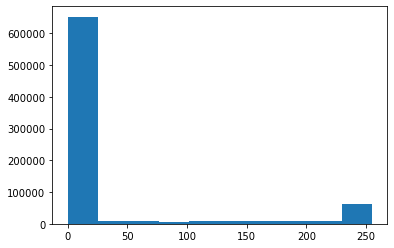

In [3]:
plt.hist(analyser.data.activation_list[0].flatten());

In [4]:
np.std(analyser.data.feature_list[0].flatten())

0.035631507950471694

In [5]:
np.std(analyser.data.feature_list[1].flatten())

0.02301646052263661

In [9]:
np.std(analyser.data.feature_list[2].flatten())

0.02066496954143529

In [10]:
np.std(analyser.data.feature_list[0].flatten())/np.std(analyser.data.feature_list[1].flatten())

1.548088070076119

In [11]:
np.std(analyser.data.feature_list[0].flatten())/np.std(analyser.data.feature_list[2].flatten())

1.7242468167701397

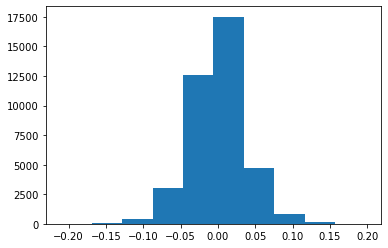

In [12]:
plt.hist(analyser.data.vh_list[0].flatten());

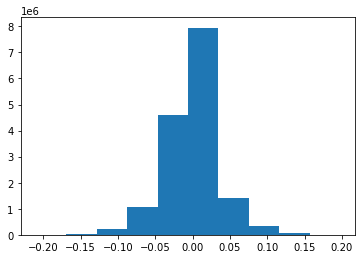

In [13]:
plt.hist(analyser.data.feature_list[0].flatten());

In [14]:
np.std(analyser.data.vh_list[0].flatten())

0.03569104

In [15]:
np.std(analyser.data.feature_list[0].flatten())

0.035631507950471694

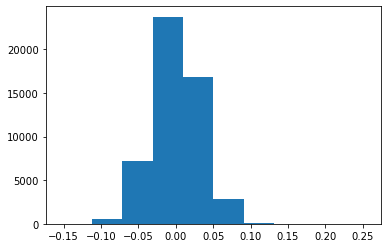

In [16]:
plt.hist(analyser.data.vh_list[1].flatten());

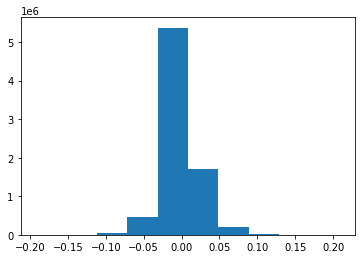

In [17]:
plt.hist(analyser.data.feature_list[1].flatten());

In [18]:
np.std(analyser.data.vh_list[1].flatten())

0.031221015

In [19]:
np.std(analyser.data.feature_list[1].flatten())

0.02301646052263661

In [20]:
np.std(analyser.data.vh_list[1].flatten())/np.std(analyser.data.feature_list[1].flatten())

1.3564646635449031

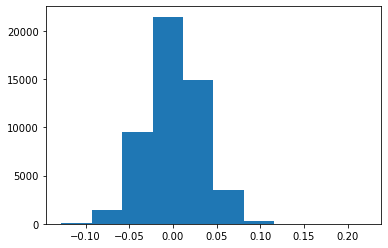

In [21]:
plt.hist(analyser.data.vh_list[2].flatten());

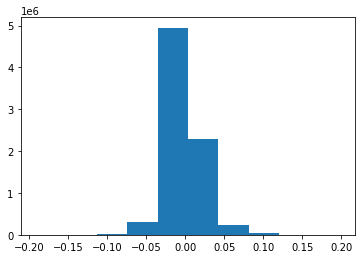

In [22]:
plt.hist(analyser.data.feature_list[2].flatten());

In [26]:
np.std(analyser.data.vh_list[2].flatten())

0.031217515

In [27]:
np.std(analyser.data.feature_list[2].flatten())

0.02066496954143529

In [28]:
np.std(analyser.data.vh_list[2].flatten())/np.std(analyser.data.feature_list[2].flatten())

1.5106489949575406

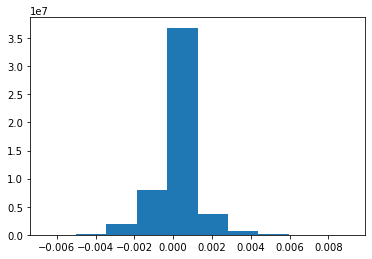

In [32]:
plt.hist(analyser.data.u_list[0].flatten());

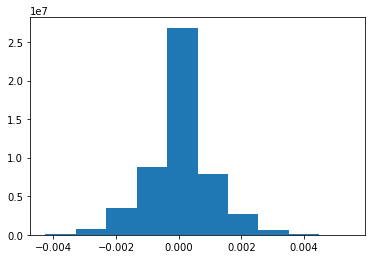

In [33]:
plt.hist(analyser.data.u_list[1].flatten());

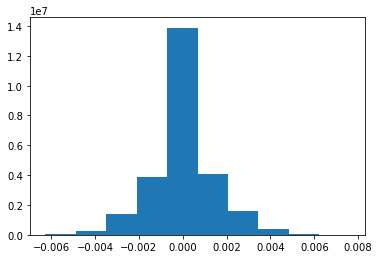

In [34]:
plt.hist(analyser.data.u_list[2].flatten());

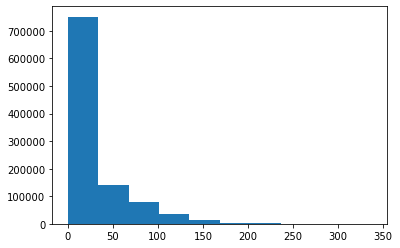

In [35]:
plt.hist(analyser.data.activation_list[1].flatten());

In [36]:
np.std(analyser.data.activation_list[1].flatten())

36.793888

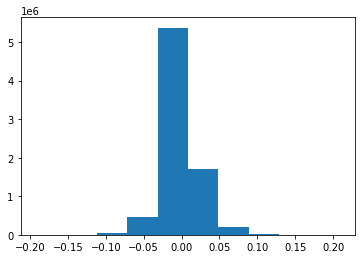

In [37]:
plt.hist(analyser.data.feature_list[1].flatten());

In [65]:
np.std(analyser.data.feature_list[1].flatten())

0.0007305147319380225

In [4]:
analyser = Analyser("mnist/dropout/", show_plots=False)
analyser.load(side="left", load_features=True)

Loading data ...


In [5]:
analyser.plotter.plot_path = "plots/outliers/"
analyser.set_k_per_layer([20, 10, 10, 10])

In [6]:
final_decision_layer = analyser.get_layer_of_final_decision()
mask = analyser.data.misclassification_mask

In [7]:
d_mis = final_decision_layer[mask]
d_cor = final_decision_layer[mask == 0]
d = [d_cor, d_mis]

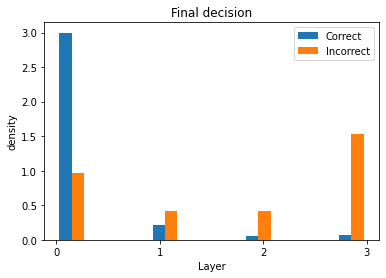

In [8]:
plt.hist(d, density=True)
plt.legend(['Correct', 'Incorrect'])
plt.xticks([0,1,2,3])
plt.ylabel('density')
plt.xlabel('Layer')
plt.title('Final decision');

In [9]:
variation = analyser.compute_variation_in_computation()

In [10]:
d_mis = variation[mask]
d_cor = variation[mask == 0]

d_mis = np.mean(d_mis, axis = 0)
d_cor = np.mean(d_cor, axis = 0)

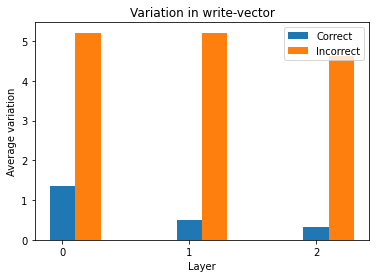

In [11]:
width = 0.2
plt.bar(np.arange(len(d_cor)), height = d_cor, width=width)
plt.bar(np.arange(len(d_mis)) + width, height = d_mis, width=width)

plt.legend(['Correct', 'Incorrect'])
plt.xticks([0,1,2])
plt.ylabel('Average variation')
plt.xlabel('Layer')
plt.title('Variation in write-vector');

In [ ]:
# combined analysis

In [24]:
mis_and_d3 = [final_decision_layer[i] == 3 and mask[i] for i in range(len(mask))]
mis_and_d1 = [final_decision_layer[i] == 1 and mask[i] for i in range(len(mask))]

var_mis_and_d3 = np.mean(variation[mis_and_d3], axis = 0)
var_mis_and_d1 = np.mean(variation[mis_and_d1], axis = 0)

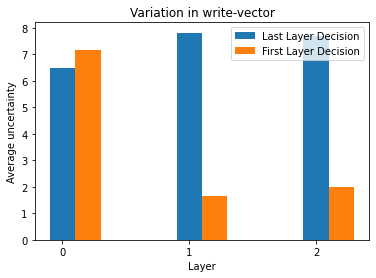

In [28]:
width = 0.2
plt.bar(np.arange(len(var_mis_and_d3)), height = var_mis_and_d3, width=width)
plt.bar(np.arange(len(var_mis_and_d1)) + width, height = var_mis_and_d1, width=width)

plt.legend(['Last Layer Decision', 'First Layer Decision'])
plt.xticks([0,1,2])
plt.ylabel('Average uncertainty')
plt.xlabel('Layer')
plt.title('Variation in write-vector');

In [31]:
np.where(mis_and_d1)

(array([235, 275, 326, 347, 352, 687]),)

In [59]:
np.where(mask)

(array([211, 235, 275, 326, 339, 347, 352, 359, 405, 431, 437, 455, 464,
        465, 467, 474, 480, 484, 498, 500, 532, 535, 547, 550, 566, 583,
        589, 593, 622, 635, 683, 687, 690, 718, 752, 768, 778, 796, 839,
        849, 850, 861, 874, 918, 926, 935, 946, 949]),)

In [47]:
analyser.data.predictions[mis_and_d3]

array([2, 2, 6, 8, 9, 9, 2, 9, 6, 3, 8, 3, 4, 8, 2, 2, 2, 2, 7, 8, 1, 8])

In [64]:
analyser.data.predictions[322]

3